## 图像定位（Image localization）

## 基础知识

**常见图像处理任务**
1. 图像分类（Image classification）：给定一张图像，判断图像中包含的物体类别。
2. 图像定位（Image localization）：给定一张图像，不仅要判断图像中包含的物体类别，还要给出物体在图像中的位置。
3. 图像语义分割（Image segmentation）：给定一张图像，不仅要判断图像中包含的物体类别，还要给出物体在图像中的位置，并进一步分割出物体在图像中的具体区域。
4. 图像目标检测（Object localization）：给定一张图像，判断图像中包含的物体类别，并给出物体在图像中的位置。
5. 图像实例分割（Instance segmentation）：给定一张图像，判断图像中包含的物体类别，并给出物体在图像中的位置，并进一步分割出物体在图像中的具体区域，同时区分出不同物体的具体区域。

**图像定位**
对于单纯的分类问题，我们只需要将图像输入到神经网络中，然后通过神经网络输出得到图像中物体的类别。然而，对于图像定位问题，我们不仅需要判断图像中物体的类别，还需要给出物体在图像中的位置，输出四个数字（x, y, w, h），图像中某一点的坐标（x, y），以及图像的宽度和高度，这样我们可以很容易的找到物体的边框。因此，我们需要在神经网络中引入定位信息，以确定物体在图像中的位置。


## 导入库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
from torchvision import transforms
import os

from lxml import etree              # conda install lxml
from matplotlib.patches import Rectangle
import glob

from PIL import Image

## 观察和理解数据

(400, 600, 3)


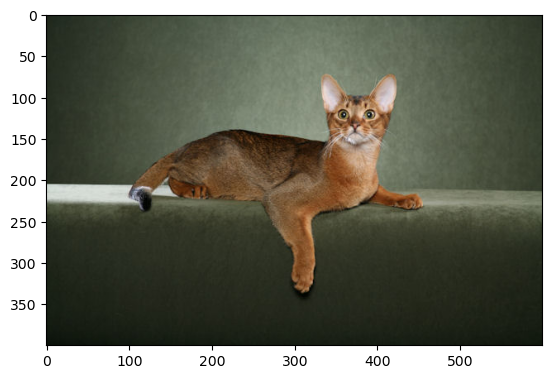

In [2]:
# 读取第一张图片
pil_img = Image.open(r'./dataset/Oxford-IIIT Pets Dataset/images/Abyssinian_1.jpg')
np_img = np.array(pil_img)
print(np_img.shape)

plt.imshow(np_img)
plt.show()

In [3]:
# 读取第一张图片的xml文件
xml = open(r'./dataset/Oxford-IIIT Pets Dataset/annotations/xmls/Abyssinian_1.xml').read()
selection = etree.HTML(xml)

# 获取图像的尺寸
width = selection.xpath('//size/width/text()')[0]
height = selection.xpath('//size/height/text()')[0]
width, height


('600', '400')

In [4]:
# 获取图像中猫头的位置
xmin = selection.xpath('//bndbox/xmin/text()')[0]
ymin = selection.xpath('//bndbox/ymin/text()')[0]
xmax = selection.xpath('//bndbox/xmax/text()')[0]
ymax = selection.xpath('//bndbox/ymax/text()')[0]
xmin, ymin, xmax, ymax

('333', '72', '425', '158')

In [5]:
# 将str转换为int
width = int(width)
height = int(height)

xmin = int(xmin)
ymin = int(ymin)
xmax = int(xmax)
ymax = int(ymax)

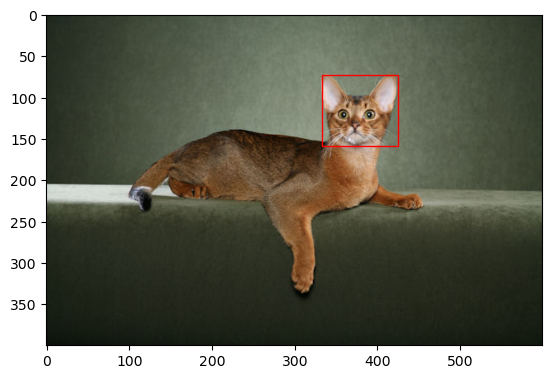

In [6]:
# 绘制图片及猫头的位置边框
plt.imshow(np_img)
rectangle = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')       # 实例化矩形框
axis = plt.gca()                    # 获取当前坐标轴，get current axis
axis.axes.add_patch(rectangle)      # 在坐标轴中添加矩形框
plt.show()

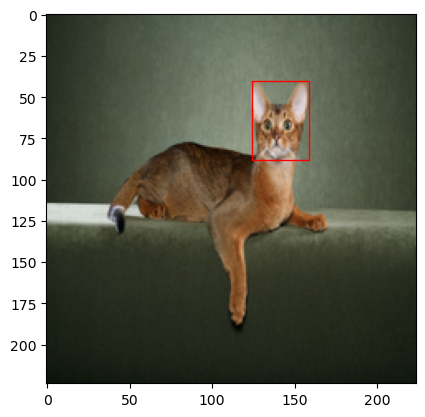

In [7]:
# 图像resize后，定位框位置的确定
resize_pil_img = pil_img.resize((224, 224))

# 定位框按缩放比例同步缩放
xmin = xmin*224/width
ymin = ymin*224/height
xmax = xmax*224/width
ymax = ymax*224/height

# 绘制图片及猫头的位置边框
plt.imshow(resize_pil_img)
rectangle = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')       # 实例化矩形框
axis = plt.gca()                    # 获取当前坐标轴，get current axis
axis.axes.add_patch(rectangle)      # 在坐标轴中添加矩形框
plt.show()

## 创建输入数据集

In [8]:
# 获取所有图片的路径
all_imgs_path = glob.glob('./dataset/Oxford-IIIT Pets Dataset/images/*.jpg')
print("Length: ", len(all_imgs_path))
all_imgs_path[:5]

Length:  7390


['./dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_1.jpg',
 './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_10.jpg',
 './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_100.jpg',
 './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_101.jpg',
 './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_102.jpg']

In [9]:
# 获取所有xml文件的路径
all_xmls_path = glob.glob('./dataset/Oxford-IIIT Pets Dataset/annotations/xmls/*.xml')
print("Length: ", len(all_xmls_path))
all_xmls_path[:5]

Length:  3686


['./dataset/Oxford-IIIT Pets Dataset/annotations/xmls\\Abyssinian_1.xml',
 './dataset/Oxford-IIIT Pets Dataset/annotations/xmls\\Abyssinian_10.xml',
 './dataset/Oxford-IIIT Pets Dataset/annotations/xmls\\Abyssinian_100.xml',
 './dataset/Oxford-IIIT Pets Dataset/annotations/xmls\\Abyssinian_101.xml',
 './dataset/Oxford-IIIT Pets Dataset/annotations/xmls\\Abyssinian_102.xml']

In [10]:
# 使用xml文件名删选进行标注的图片
# 分离xml文件名
xmls_names = [x.split('\\')[-1].split('.xml')[0] for x in all_xmls_path]
# 例如：'./dataset/Oxford-IIIT Pets Dataset/annotations/xmls\\Abyssinian_1.xml' -> 'Abyssinian_1'
print("xmls_names Length: ", len(xmls_names))
xmls_names[:5]

xmls_names Length:  3686


['Abyssinian_1',
 'Abyssinian_10',
 'Abyssinian_100',
 'Abyssinian_101',
 'Abyssinian_102']

In [11]:
# 删选有标注的图片
xmls_imgs_path = [img for img in all_imgs_path 
        if img.split('\\')[-1].split('.jpg')[0] in xmls_names]
# 例如：'./dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_1.jpg' -> 'Abyssinian_1' 得到的 'Abyssinian_1' 在 xmls_names 中，则保留
print("xmls_names Length: ", len(xmls_names))
print("xmls_imgs_path Length: ", len(xmls_imgs_path))
xmls_imgs_path[:5], xmls_names[:5]

xmls_names Length:  3686
xmls_imgs_path Length:  3686


(['./dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_1.jpg',
  './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_10.jpg',
  './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_100.jpg',
  './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_101.jpg',
  './dataset/Oxford-IIIT Pets Dataset/images\\Abyssinian_102.jpg'],
 ['Abyssinian_1',
  'Abyssinian_10',
  'Abyssinian_100',
  'Abyssinian_101',
  'Abyssinian_102'])

In [12]:
# 从xml文件中解析出标注信息，转化为比例格式，便于图像resize后，定位框位置的确定
def xml_to_label(path):
    xml = open(r'{}'.format(path)).read()
    selection = etree.HTML(xml)
    width = int(selection.xpath('//size/width/text()')[0])
    height = int(selection.xpath('//size/height/text()')[0])
    xmin = int(selection.xpath('//bndbox/xmin/text()')[0])
    ymin = int(selection.xpath('//bndbox/ymin/text()')[0])
    xmax = int(selection.xpath('//bndbox/xmax/text()')[0])
    ymax = int(selection.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width, ymin/height, xmax/width, ymax/height]

In [13]:
# 从xml文件中解析出标注信息
xmls_labels = [xml_to_label(path) for path in all_xmls_path]
# 数据集划分，将图片和标签进行同步的乱序
np.random.seed(2021)        # 随机种子，保证每次划分结果一致
random_index = np.random.permutation(len(xmls_imgs_path))    # 创建与数据集等长的乱序索引random_index
xmls_imgs_path = np.array(xmls_imgs_path)[random_index]    # 对图片使用random_index进行索引
xmls_labels = np.array(xmls_labels)[random_index].astype(np.float32)          # 对标签使用random_index进行索引

In [14]:
# 划分训练集和测试集，训练集占80%，测试集占20%
s = int(len(xmls_imgs_path)*0.8)
print(s)
train_imgs = xmls_imgs_path[:s]
train_labels = xmls_labels[:s]
test_imgs = xmls_imgs_path[s:]
test_labels = xmls_labels[s:]

2948


In [15]:
type(train_labels)

numpy.ndarray

## 自定义数据类

In [16]:
# 图片变换
transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
])

In [17]:
# 自定义数据集类
class Oxford_Dataset(data.Dataset):
    def __init__(self, images, lables):
        self.images = images
        self.lables = lables

    def __getitem__(self, index):
        images = self.images[index]

        pil_img = Image.open(images)               # PIL读取图片

        # 图片不全是RGB格式，有些是灰度图，需要转换成RGB格式（复制三份，使channel=3）
        np_img = np.asarray(pil_img, dtype=np.uint8)        # PIL转Numpy（ndarray）
        # 将灰度图转换为RGB图
        if len(np_img.shape) == 2:
            np_img = np.repeat(np_img[:, :, np.newaxis], 3, axis=2)       # [H, W] -> [H, W, 3]
            pil_img = Image.fromarray(np_img)               # 转换回PIL格式
        
        tensor_img = transform(pil_img)                     # PIL转Tensor

        lables = self.lables[index]         # [xmin/width, ymin/height, xmax/width, ymax/height]
        lable_1, lable_2, lable_3, lable_4 =lables.reshape(-1, 1)
        
        return (tensor_img, lable_1, lable_2, lable_3, lable_4)

    def __len__(self):
        return len(self.images)

In [18]:
# 实例化划分后的数据集
train_ds = Oxford_Dataset(images=train_imgs, lables=train_labels)
test_ds = Oxford_Dataset(images=test_imgs, lables=test_labels)

BATCH_SIZE = 32

train_dl = data.DataLoader(dataset=train_ds,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           pin_memory=True
)
test_dl = data.DataLoader(dataset=test_ds,
                          batch_size=BATCH_SIZE,
                          pin_memory=True
)

In [19]:
# 取出一个batch的图片和标签
(imgs_batch, out1_batch, out2_batch, out3_batch, out4_batch)= next(iter(train_dl))
imgs_batch.shape, out1_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1]))

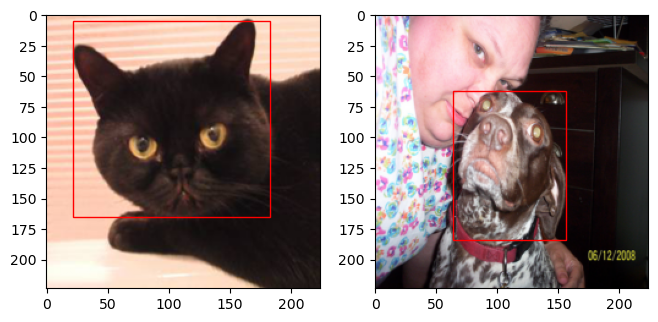

In [20]:
# 可视化batch图片数据
plt.figure(figsize=(12, 8))
# zip()同时对imgs_batch和labels_batch进行迭代，enumerate()添加序号方便绘制子图
for i,(img, label1, label2, label3, label4,) in enumerate(zip(imgs_batch[:2],
                                                              out1_batch[:2], 
                                                              out2_batch[:2], 
                                                              out3_batch[:2], 
                                                              out4_batch[:2])):
    # img = (img.permute(1,2,0).numpy() + 1)/2    # 将tensor数据转化为numpy数据，并反归一化
    img = img.permute(1,2,0).numpy()
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    xmin, ymin, xmax, ymax = label1*224, label2*224, label3*224, label4*224, 
    rectangle = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')       # 实例化矩形框
    axis = plt.gca()                    # 获取当前坐标轴，get current axis
    axis.axes.add_patch(rectangle)      # 在坐标轴中添加矩形框

## 创建定位模型

In [21]:
# 加载预训练模型
resnet = torchvision.models.resnet101(weights='IMAGENET1K_V2')
# 创建卷积基
# conv_base = nn.Sequential(*list(resnet.children())[:-1])            # 取resnet的卷积基, *表示将list中的元素解包
# 获取卷积基的输出特征数
in_size = resnet.fc.in_features
print(in_size)

2048


In [22]:
# 定义定位模型
class Local_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_base = nn.Sequential(*list(resnet.children())[:-1])       # 取resnet的卷积基, *表示将list中的元素解包
        self.fc1 = nn.Linear(in_size, 1)
        self.fc2 = nn.Linear(in_size, 1)
        self.fc3 = nn.Linear(in_size, 1)
        self.fc4 = nn.Linear(in_size, 1)

    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), -1)
        y1 = self.fc1(x)
        y2 = self.fc2(x)
        y3 = self.fc3(x)
        y4 = self.fc4(x)
        return y1, y2, y3, y4 

In [23]:
local_net = Local_Net()
# 参数整理
model = local_net
learn_rate = 0.0001
epochs = 10
train_dl = train_dl
test_dl = test_dl

# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model.to(device) # 将已实例化的模型移动到GPU上

# 回归问题，使用均方误差损失函数
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=learn_rate) # 优化器，Adam优化器

# 学习率调整器
from torch.optim import lr_scheduler

# # 手动调整学习率
# for param_group in opt.param_groups:
#     print(param_group['lr'])
#     param_group['lr'] *= 0.9

exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1) # 每隔7个epoch，学习率衰减为原来的0.1倍

# lr_scheduler.MultiStepLR(opt, milestones=[5, 10, 15, 20], gamma=0.5) # 每隔5个epoch，学习率衰减为原来的0.1倍
# lr_scheduler.ExponentialLR(opt, gamma=0.5) # 每个epoch，学习率衰减为原来的0.5倍

In [24]:
# 通用训练模板，输入模型、训练数据、测试数据，返回loss和acc变化
# 训练函数
def train(train_dl, model, loss_fn, opt, exp_lr_scheduler):
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失

    for x, y1, y2, y3, y4 in train_dl: # 遍历数据集
        x, y1, y2, y3, y4 = x.to(device), y1.to(device), y2.to(device), y3.to(device), y4.to(device) # 将数据移动到GPU上

        y_pred1, y_pred2, y_pred3, y_pred4 = model(x)
        loss1 = loss_fn(y_pred1, y1)
        loss2 = loss_fn(y_pred2, y2)
        loss3 = loss_fn(y_pred3, y3)
        loss4 = loss_fn(y_pred4, y4)
        loss = loss1 + loss2 + loss3 + loss4 # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失

    exp_lr_scheduler.step() # 学习率调整
    train_loss /= num_batches # 计算平均损失

    return train_loss

# 测试函数
def test(test_dl, model, loss_fn):
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失

    with torch.no_grad(): # 不计算梯度
        for x, y1, y2, y3, y4 in test_dl: # 遍历数据集
            x, y1, y2, y3, y4 = x.to(device), y1.to(device), y2.to(device), y3.to(device), y4.to(device) # 将数据移动到GPU上

            y_pred1, y_pred2, y_pred3, y_pred4 = model(x)
            loss1 = loss_fn(y_pred1, y1)
            loss2 = loss_fn(y_pred2, y2)
            loss3 = loss_fn(y_pred3, y3)
            loss4 = loss_fn(y_pred4, y4)
            loss = loss1 + loss2 + loss3 + loss4
            test_loss += loss.item() # 计算损失

    test_loss /= num_batches # 计算平均损失

    return test_loss

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt, exp_lr_scheduler):
    train_loss = []
    test_loss = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}'


    for epoch in range(epochs):
        model.train() # 设置模型为训练模式，启用dropout层
        epoch_train_loss = train(train_dl, model, loss_fn, opt, exp_lr_scheduler)
        model.eval() # 设置模型为评估预测模式，禁用dropout层
        epoch_test_loss = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        test_loss.append(epoch_test_loss)

        print(print_template.format(epoch, epoch_train_loss, epoch_test_loss))

    return train_loss, test_loss

# 训练
train_loss, test_loss, = fit(epochs, model, train_dl, test_dl, loss_fn, opt, exp_lr_scheduler)

Epoch: 0, Train Loss: 0.1485, Test Loss: 0.0807
Epoch: 1, Train Loss: 0.0294, Test Loss: 0.1388
Epoch: 2, Train Loss: 0.0141, Test Loss: 0.0361
Epoch: 3, Train Loss: 0.0092, Test Loss: 0.0756
Epoch: 4, Train Loss: 0.0076, Test Loss: 0.0416
Epoch: 5, Train Loss: 0.0070, Test Loss: 0.0962
Epoch: 6, Train Loss: 0.0058, Test Loss: 0.0198
Epoch: 7, Train Loss: 0.0044, Test Loss: 0.1433
Epoch: 8, Train Loss: 0.0044, Test Loss: 0.0907
Epoch: 9, Train Loss: 0.0036, Test Loss: 0.0988


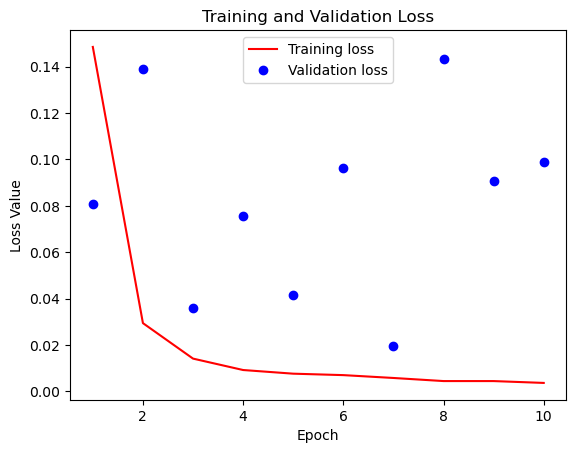

In [25]:
plt.figure()
plt.plot(range(1, len(train_loss)+1), train_loss, 'r', label='Training loss')
plt.plot(range(1, len(train_loss)+1), test_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# 模型保存

In [26]:
PATH = './model/Image_localization.pth'

In [27]:
torch.save(model.state_dict(), PATH)

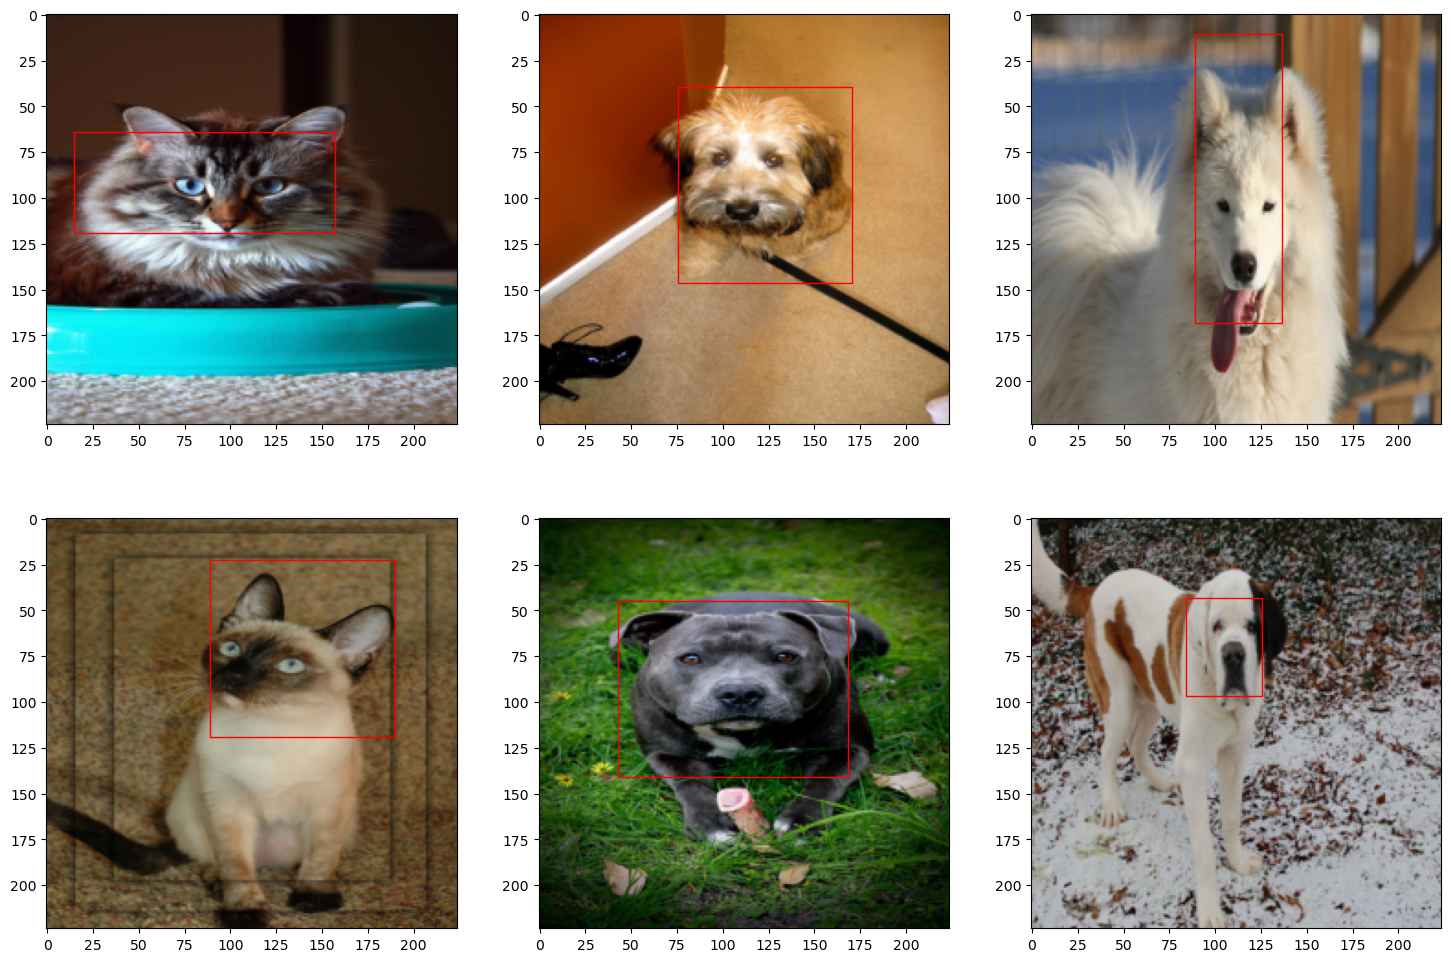

In [31]:
plt.figure(figsize=(18, 12))
imgs, _, _, _, _ = next(iter(test_dl))
imgs = imgs.to(device)
out1, out2, out3, out4 = model(imgs)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(imgs[i].permute(1,2,0).cpu().numpy())
    xmin, ymin, xmax, ymax = (out1[i].item()*224, 
                              out2[i].item()*224, 
                              out3[i].item()*224, 
                              out4[i].item()*224)
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    ax = plt.gca()
    ax.axes.add_patch(rect)